# Diffusion+Forcing+Advection in 2D

***Shaunticlair Ruiz (based on document by Ian Fenty)***
***2024-7-8***


This notebook builds on the previous Diffusion+Forcing notebook, and introduces Advection.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import helper

We borrow the following functionality from previous notebooks, saved in the helper.py file:

- ```helper.compute_linear_time_evolution_simple(c0, M, num_saved_timesteps, duration_per_saved_timestep, debug = False)```

- ```helper.compute_affine_time_evolution_simple(c0, M, r, num_saved_timesteps, duration_per_saved_timestep, debug = False)```

- ```helper.plot_1d_heatmap_time_evolution(saved_timesteps, state_over_time)```

- ```helper.plot_2d_heatmap_time_evolution(saved_timesteps, state_over_time, nr, nc)```

- ```helper.add_random_circles(matrix, num_circles, radius, values)```

-------
# 1D Spatially-Variant Advection

-------

### Framing 1D Spatially-Variant Advection

For this section, we'll ignore diffusion: we can bring it back later. 

Instead of having substance passively drift from high concentration to low concentration, we'll *actively* move it from one cell to another.

- We could model this as salty water, flowing from one cell to another (where the salt itself is our "substance" of interest)

- Transferring substance in this way is known as **advection**.

As before, each cell has a substance $z_i$, where concentration is $c_i$. But this time, we will have "flow" from one cell to another, at velocity $v_i$.

- The velocity on the boundary between cells $i-1$ and $i$ is given by $v_i$.
  - In other words, $v_i$ represents the velocity on the left boundary of cell $i$.
  - There are $n+1$ of these values.

In [2]:
n = 10

dx = 1
Z = np.random.rand(10)

v = np.array([1]*(n+1))

C = Z / dx

### Deriving 1D Spatially-Variant Advection

Let's start with the boundary between $i-1$ and $i$.

- Advection is different from diffusion: in diffusion, material is flowing in both directions, because our substance is passively drifting.
- In advection, all of the material is moving in the same direction, according to the flow of the "water".

$$\begin{bmatrix}\cdots & c_{i-1} & \to & c_{i} & \cdots\end{bmatrix} $$

Let's select a small timestep $\Delta t$. Suppose we have some velocity $v_i$. How much material $\Delta z$ is moving during that timestep?

We'll start with the left side.


### $v_i \geq 0$ case

In advection, it matters whether our water is flowing left or right.

If $v_i>0$, then our "fluid" is flowing right, entering cell $i$ from cell $i-1$. How much $z$ are we moving?

- We're moving a small block of "water". The substance $z$ in that block of water is the volume $V\llap{--\;}$ of that water, times the concentration $c$ of that unit.

$$\Delta z^{LEFT}_i \approx V\llap{--\;} c$$

- When water is flowing, the volume that is moved in time $\Delta t$ is cross-section area $\alpha_i$ times velocity $v_i$, times $\Delta t$. Let's assume $\alpha_i=1$, for our 1D case.

$$V\llap{--\;} \approx \alpha_i v_i \Delta t = v_i \Delta t$$

- What's the concentration of this water? Well, the concentration on the left side (where the water is coming from) is $c_{i-1}$.

Combining all of this, we find:

$$\frac{\Delta z^{LEFT}_i}{\Delta t} \approx v_ic_{i-1}$$



### $v_i<0$ case

What if $v_i<0$? Instead, substance is leaving the left side: 

- The fact that it's leaving is captured by the negative sign in $v_i$.

- Because it's leaving cell $i$, rather than $c_{i-1}$, we'll need a different concentration:

$$\frac{\Delta z^{LEFT}_i}{\Delta t} \approx v_ic_{i}$$

So, we have two cases:

$$\frac{\Delta z^{LEFT}_i}{\Delta t} \approx 
\begin{cases} 
    v_ic_{i-1} & v_i \geq 0 \\
    v_ic_i     & v_i < 0
\end{cases}$$

When we're writing code, it might be easier to instead use a different form: let's use the $\operatorname{min}$ and $\operatorname{max}$ functions.

$$\frac{\Delta z^{LEFT}_i}{\Delta t} \approx 
\max(v_i,0)c_{i-1} + \min(v_i,0)c_i$$

The "max" case is only relevant if $v_i$ is positive, and the "min" case is only relevant if $v_i$ is negative.


If we repeat this process for the right side, we get a similar function:

$$\frac{\Delta z^{RIGHT}_i}{\Delta t} \approx 
-\max(v_{i+1},0)c_{i} - \min(v_{i+1},0)c_{i+1}$$

In [3]:
C_I = C

C_IP1 = np.roll(C, -1) #Roll the array so index=0 accesses the last element
C_IM1 = np.roll(C, 1)  #Roll the array so index=-1 accesses the first element

V_I = v[:-1]

#Roll the array to the left by 1
V_IP1 = v[1:]

dZleft_dt  =  np.max(V_I, 0)   * C_IM1 + np.min(V_I, 0) * C_I 
dZright_dt = -np.max(V_IP1, 0) * C_I   - np.min(V_IP1, 0) * C_IP1

If we combine $\Delta z^{LEFT}_i$ and $\Delta z^{RIGHT}_i$, we get the total change in cell $i$:

$$\frac{\Delta z_i}{\Delta t} \approx  \max(v_i,0)c_{i-1} + \min(v_i,0)c_i - \max(v_{i+1},0)c_{i} - \min(v_{i+1},0)c_{i+1} $$

We can divide by $\Delta x$ to get a change in concentration:

$$\frac{\Delta c_i}{\Delta t} \approx\Big( \max(v_i,0)c_{i-1} + \min(v_i,0)c_i - \max(v_{i+1},0)c_{i} - \min(v_{i+1},0)c_{i+1} \Big) / \Delta x $$

In [4]:
dZ_dt = dZleft_dt + dZright_dt
dC_dt = dZ_dt / dx

### Quick aside: continuous form, partial differential equation for Advection

We can take a continuous limit $\Delta t \to 0$, to get an accurate derivative. There's just one more thing we need to take care of first:

- We assume that our flow is *incompressible*, or *conservative*: we have a constant amount of "water" in each cell. What goes in, must come out.

- In our case, the volume that goes in or out during time $\Delta t$ is $v_i \alpha_i \Delta t$ on the left, and $v_{i+1} \alpha_{i+1} \Delta t$ on the right.
  - We have already assumed that every cell has $\alpha_i=1$.

$$v_i \Delta t = v_{i+1} \Delta t \implies v_i = v_{i+1}$$

If we apply this to our equation, it simplifies a bit:

$$\frac{\Delta c_i}{\Delta t} \approx  \max(v_i,0) \Big( \frac{c_{i-1} - c_{i}}{\Delta x} \Big) + \min(v_i,0) \Big( \frac{c_{i} - c_{i+1}}{\Delta x} \Big)  $$

We replace the appropriate terms with derivatives:

$$\frac{\partial c_i}{\partial t}  \approx  -\max(v_i,0) \frac{\partial c_i}{\partial x} - \min(v_i,0) \frac{\partial c_i}{\partial x}  $$

One of these terms always vanishes: either $v_i \geq 0$, or $v_i <0$. In either case, we can simplify:

$$\frac{\partial c_i}{\partial t} = -v_i \Big( \frac{\partial c_i}{\partial x} \Big) $$

This is the advective component of the equation for the advective-diffusive model. We'll come back to this.

### Forward Simulation of Advective 1D

We'll use our discretization to implement advection in time. Each timestep, we update our current concentrations:

$$c_i(t+1) \approx c_i(t) + \frac{\partial c_i}{\partial t} \Delta t$$

This derivative is approximated by our current concentrations:

$$c_i(t+1) \approx c_i(t) + \Big( \max(v_i,0)c_{i-1} + \min(v_i,0)c_i - \max(v_{i+1},0)c_{i} - \min(v_{i+1},0)c_{i+1} \Big) \frac{\Delta t}{\Delta x} $$



We'll substitute in $\beta$, the same trick we've used before: 

$$\beta = \frac{\Delta t}{\Delta x}$$

And we rearrange to get a linear(?) model:

$$c_i(t+1) \approx \Big( 1 + \beta \min(v_i,0) - \beta\max(v_{i+1},0)\Big) c_i(t) + \beta \max(v_i,0) c_{i-1}(t) - \beta\min(v_{i+1},0) c_{i+1}(t)    $$

Thus, we encode the model as a linear system $c(t+1) \approx Mc(t)$, where $c(t)$ is a column vector.

In [5]:
def make_M_1d_advection(n: int, dt: float, dx: float,
                        v: np.ndarray,
                        cyclic: bool = True):
    """
    Creates linear model M which can be used to forward-simulate a discrete approximation of advection in 1D.

    c(t+1) = Mc(t)

    n:      the number of discrete cells.
    dt:     duration of a timestep
    dx:     the distance between the centers of cells in adjacent columns
    v:      the velocity constant matrix along the x-axis (between columns)
                v[i] gives the velocity at the boundary between cells i-1 and i

    cyclic: if True, cell 0 is east of cell n-1
                This is taken as default, because otherwise no advection would occur

    """

    if v.shape != (n+1,):
        raise ValueError("v doesn't have the right shape for your dimensions!")
    if not cyclic: #No flow occurs.
        v = np.zeros_like(v)
    #if not np.all(v == v[0]):
    #    raise ValueError("v must be uniform for 1D advection")



    M = np.zeros((n, n))

    beta = dt / (dx)

    V_I = v[:-1]
    V_IP1 = v[1:]

    # Calculate Q values using numpy logic
    a_IM1 = beta * np.maximum(V_I, 0)
    a_IP1 = - beta * np.minimum(V_IP1, 0)
    a_I = 1 + beta * np.minimum(V_I,0) - beta * np.maximum(V_IP1,0)

    # Check if any Q_IMI values are 0
    if np.any(a_I < 0):
        raise ValueError("confusion")

    for i in range(n):
        M[i, i] = a_I[i]
        
        if i > 0:
            M[i, i-1] = a_IM1[i]
        elif cyclic:
            M[i, -1] = a_IM1[i]
        
        if i < n-1:
            M[i, i+1] = a_IP1[i]
        elif cyclic:
            M[i, 0] = a_IP1[i]

    return M




n = 100


Now, we can simulate this model forward in time:

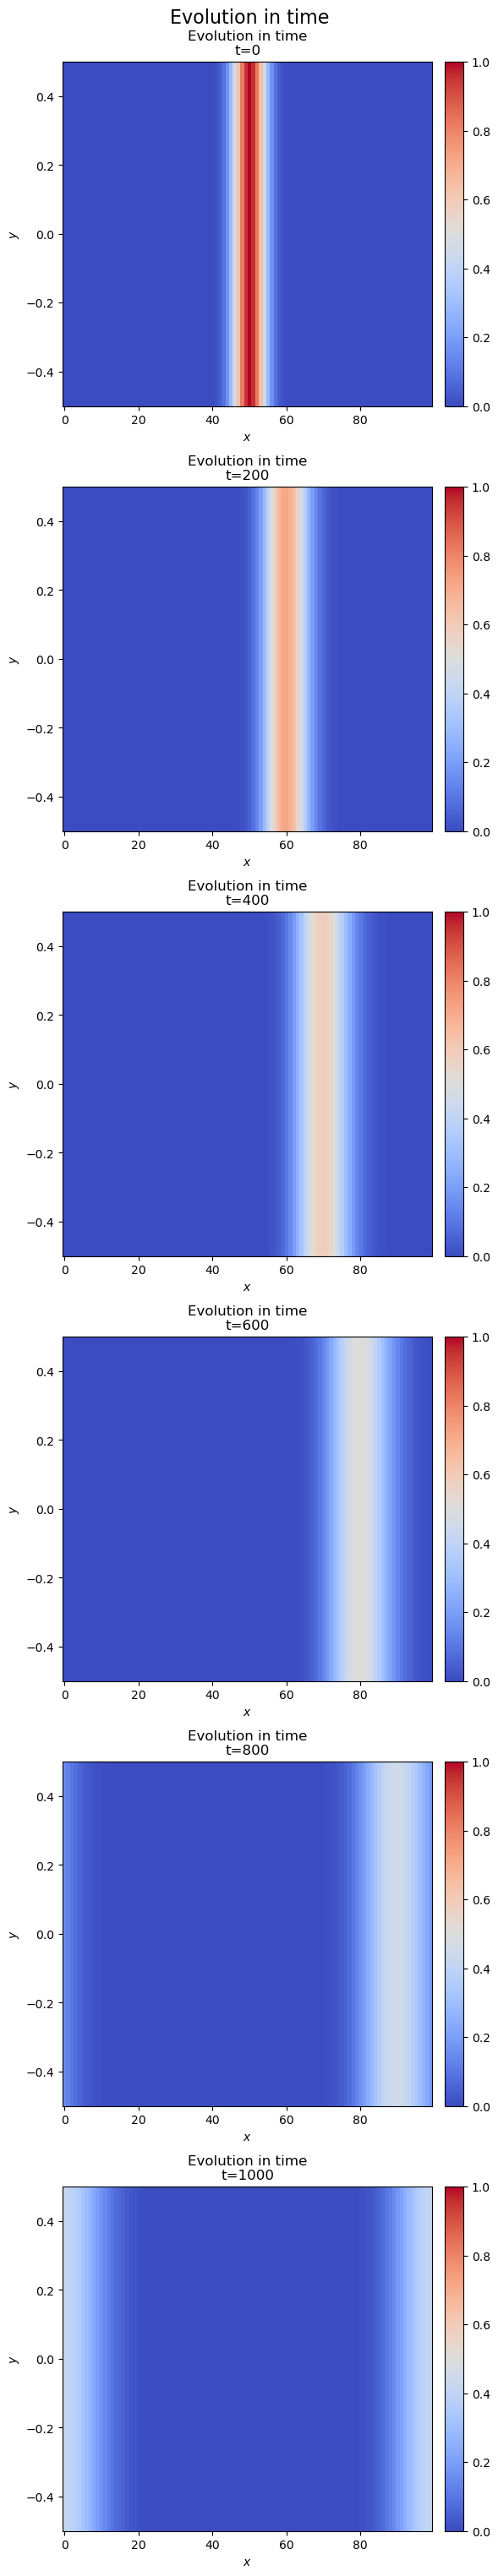

In [6]:
M = make_M_1d_advection(n = n, dt = 0.01, dx = 0.1, 
                        v = np.array([0.5]*(n+1)))

c0 = np.exp(
            -(np.arange(n)-n//2)**2
            /(n/5)
        ) #+ np.arange(n)**2


num_saved_timesteps = 6
duration_per_saved_timestep = 200

saved_timesteps, state_over_time = helper.compute_linear_time_evolution_simple(
                                    c0, M, num_saved_timesteps, duration_per_saved_timestep)
helper.plot_1d_heatmap_time_evolution(saved_timesteps, state_over_time)

Notably, we have some "numerical diffusion" going on: even though our advective model is supposed to only shift our distribution, it also appears to be smearing it out, as well.

We'll ignore this inaccuracy for the time being.

### A few comments about the 1d advection model

This model is very limited:

- Because "what comes in, must come out", the velocities on either side of a cell must be the same.
  - By induction, this means that the velocities between every pair of cells is exactly the same. This is a bit boring.

- If we don't allow our model to be cyclic, no flow occurs at all: because the leftmost boundary has no flow, no other boundaries can have flow, either.

So, despite the fact that we allowed multiple different $v_i$, they *have* to be the same, for a realistic model.

- We used variable $v_i$ for the sake of extending to our next model: 2d advection + diffusion + forcing.

-------
# 2D SV Diffusion + SV Advection + Forcing

-------

### Framing 2D SV Advection

In 2D, we now have advection along two axes:

- The northward velocity flowing from cell $(i-1,j)$ to $(i,j)$ is $V^Y_{ij}$.
  - Matrix $V^Y$ has shape $(nr+1,nc)$.
- The eastward velocity flowing from cell $(i,j-1)$ to $(i,j)$ is $V^X_{ij}$.
  - Matrix $V^X$ has shape $(nr,nc+1)$.

### Deriving 1D SV Advection in 2D space

Let's start by re-deriving 1D advection, with the knowledge that we're operating in a 2D space. We'll focus on only advection along the $x$-axis, for now.

- We'll focus on the western side. We have some volume of water $V\llap{--\;}_{ij}$ coming in from this side. The amount of $z$ is coming in is:

$$\Delta z_{ij}^{WEST} \approx V\llap{--\;}_{ij} c$$

- The volume coming in is the cross-section area (the vertical cell length $\Delta Y^G_{ij}$), times the velocity from the western side ($V^X_{ij}$), and the duration of time $\Delta t$.

$$\Delta z_{ij}^{WEST} \approx (\Delta Y^G_{ij} V^X_{ij} \Delta t ) c$$

- The concentration is coming from the left cell, so we want concentration $c_{(i,j-1)}$.

$$\Delta z_{ij}^{WEST} \approx (\Delta Y^G_{ij} V^X_{ij} \Delta t ) c_{(i,j-1)}$$

- We'll divide out $\Delta t$ to get a derivative approximation. 

- We also want to turn this into a concentration: we need to divide by the area/volume of the cell, $A_{ij}$ (or $RAC$).

$$\frac{\Delta c_{ij}^{WEST}}{\Delta t} \approx \Big( \frac{\Delta Y^G_{ij} V^X_{ij}}{A_{ij}} \Big) c_{(i,j-1)}$$





This, of course, only applies if $V^X_{ij} \geq 0$. We have two cases, once again:

$$\frac{\Delta c_{ij}^{WEST}}{\Delta t} \approx 
\begin{cases} 
    \Big( \frac{\Delta Y^G_{ij} V^X_{ij}}{A_{ij}} \Big) c_{(i,j-1)}     & V^X_{ij} \geq 0 \\
    \Big( \frac{\Delta Y^G_{ij} V^X_{ij}}{A_{ij}} \Big) c_{(i,j)}       & V^X_{ij} < 0
\end{cases}$$

Let's repeat for the eastern side:

$$\frac{\Delta c_{ij}^{EAST}}{\Delta t} \approx 
\begin{cases} 
    -\Big( \frac{\Delta Y^G_{(i,j+1)} V^X_{(i,j+1)}}{A_{ij}} \Big) c_{(i,j)}     & V^X_{ij} \geq 0 \\
    -\Big( \frac{\Delta Y^G_{(i,j+1)} V^X_{(i,j+1)}}{A_{ij}} \Big) c_{(i,j+1)}       & V^X_{ij} < 0
\end{cases}$$

Based on these examples, we can create some shorthand (again). We'll use the third term, $Q$, for our north-south flow.

$$
\beta_{ij} = \frac{\Delta t}{A_{ij}} \qquad \qquad 
R_{ij} = \Delta Y^G_{ij} V^X_{ij}    \qquad \qquad 
Q_{ij} = \Delta X^G_{ij} V^Y_{ij}
$$

Based on our shorthand, we find:

$$\Delta c_{ij}^{WEST} \approx 
\begin{cases} 
    \beta_{ij} R_{ij} c_{(i,j-1)}     & R_{ij} \geq 0 \\
    \beta_{ij} R_{ij} c_{ij}        & R_{ij} < 0
\end{cases}
\qquad
\Delta c_{ij}^{EAST} \approx 
\begin{cases} 
    -\beta_{ij} R_{(i,j+1)} c_{ij}     & R_{ij} \geq 0 \\
    -\beta_{ij} R_{(i,j+1)} c_{(i,j+1)}        & R_{ij} < 0
\end{cases}
$$

### Deriving 2D SV Advection in 2D space

We can reproduce the exact same work along the other axis. In doing so, we find:

$$\Delta c_{ij}^{SOUTH} \approx 
\begin{cases} 
    \beta_{ij} Q_{ij} c_{(i-1,j)}     & Q_{ij} \geq 0 \\
    \beta_{ij} Q_{ij} c_{ij}        & Q_{ij} < 0
\end{cases}
\qquad
\Delta c_{ij}^{NORTH} \approx 
\begin{cases} 
    -\beta_{ij} Q_{(i+1,j)} c_{ij}     & Q_{ij} \geq 0 \\
    -\beta_{ij} Q_{(i+1,j)} c_{(i+1,j)}        & Q_{ij} < 0
\end{cases}
$$

If we combine all four of these, and convert them into max/min equations, we get our combined result:

$$
\begin{align*}
\Delta c_{ij} \approx & \beta_{ij} 
\Big( 
\max(Q_{ij},0)c_{(i-1,j)} + \min(Q_{ij},0)c_{ij} - \max(Q_{(i+1,j)},0)c_{ij} - \min(Q_{(i+1,j)},0)c_{(i+1,j)}  \\
&+\max(R_{ij},0)c_{(i,j-1)} + \min(R_{ij},0)c_{ij} - \max(R_{(i,j+1)},0)c_{ij} - \min(R_{(i,j+1)},0)c_{(i,j+1)}
\Big) 
\end{align*}
$$



As always, our simulation equation takes the form

$$c_{i,j}(t+1) \approx c_{i,j}(t) + \frac{\partial c_{i,j}}{\partial t} \cdot \Delta t$$

- Our $\Delta c_{ij}$ term above represents $\frac{\partial c_{i,j}}{\partial t} \cdot \Delta t$.

 Now, we just need to rearrange this into our "linear" form:

$$ 
\begin{align*}
c_{i,j}(t+1) \approx  & 
\Big( 1 + \beta_{ij} \big( \min(Q_{ij},0)  - \max(Q_{(i+1,j)},0) + \min(R_{ij},0)  - \max(R_{(i,j+1)},0) \big) \Big) \cdot c_{ij}(t) \\
&\qquad \qquad \qquad \qquad \qquad
+ \Big( \max(Q_{ij},0)\beta_{ij} \Big) c_{(i-1,j)} - \Big( \min(Q_{(i+1,j)},0)\beta_{ij} \Big) \cdot c_{(i+1,j)}(t) \\
&\qquad \qquad \qquad \qquad \qquad
+ \Big( \max(R_{ij},0)\beta_{ij} \Big) c_{(i,j-1)} - \Big( \min(R_{(i,j+1)},0)\beta_{ij} \Big) \cdot c_{(i,j+1)}(t)
\end{align*}
$$

This can be represented in the form

$$c(t+1) = Mc(t)$$

### Integrating 2D Advection with our Diffusion-Forcing Model

As always, our simulation equation takes the form

$$c_{i,j}(t+1) \approx c_{i,j}(t) + \frac{\partial c_{i,j}}{\partial t} \cdot \Delta t$$

or

$$c_{i,j}(t+1) \approx c_{i,j}(t) + \Delta c_{ij}$$

Each of our components (diffusion, forcing, advection) contributes in parallel to this $\Delta c_{ij}$ term. So, we'll break it up along those terms:

$$\Delta c_{ij} = \Delta c_{ij}^{dif} + \Delta c_{ij}^{for} + \Delta c_{ij}^{adv} $$

Let's write those out, copying from above:


$$\begin{align*} 
\Delta c_{ij}^{dif} \approx & 
\Big( - \beta_{ij}(T_{(i+1,j)}  + T_{ij}  + S_{(i,j+1)} + S_{ij}) \Big) c_{ij} \\
&+\Big( T_{(i+1,j)}\beta_{ij} \Big) c_{(i+1,j)} +\Big( T_{ij}\beta_{ij} \Big)   c_{(i-1,j)} \\
&+\Big( S_{(i,j+1)}\beta_{ij} \Big) c_{(i,j+1)}+\Big( S_{ij}\beta_{ij} \Big)   c_{(i,j-1)} \\
\end{align*}$$

$$
\begin{align*}
\Delta c_{ij}^{adv} \approx  & 
\Big( \beta_{ij} \big( \min(Q_{ij},0)  - \max(Q_{(i+1,j)},0) + \min(R_{ij},0)  - \max(R_{(i,j+1)},0) \big) \Big) c_{ij} \\
&+ \Big( \max(Q_{ij},0)\beta_{ij} \Big) c_{(i-1,j)} - \Big( \min(Q_{(i+1,j)},0)\beta_{ij} \Big) c_{(i+1,j)} \\
&+ \Big( \max(R_{ij},0)\beta_{ij} \Big) c_{(i,j-1)} - \Big( \min(R_{(i,j+1)},0)\beta_{ij} \Big) c_{(i,j+1)}
\end{align*}
$$

$$
\Delta c_{ij}^{for} \approx 
F (f_{ij} - c_{ij})
$$



Our goal is to represent all of this, collectively, in the form

$$c(t+1) \approx M c(t)+ r$$

We just need to add the terms together. In order to avoid the mess of terms above, we'll simplify our notation one last time:

$$\begin{align*} 
\Delta c_{ij}^{dif} \approx &
d_{ij} c_{ij} + d_{(i+1,j)}c_{(i+1,j)} +d_{(i-1,j)}c_{(i-1,j)} +
d_{(i,j+1)} c_{(i,j+1)}+d_{(i,j-1)}c_{(i,j-1)} 
\\
\Delta c_{ij}^{adv} \approx  & 
a_{ij} c_{ij} + a_{(i+1,j)}c_{(i+1,j)} +a_{(i-1,j)}c_{(i-1,j)} +
a_{(i,j+1)} c_{(i,j+1)}+a_{(i,j-1)}c_{(i,j-1)} 
\\
\Delta c_{ij}^{for} \approx &
- Fc_{ij} + Ff_{ij} 
\end{align*}
$$

Combining this all together, we get:

$$\begin{align*} 
c_{ij}(t+1) \approx &
\Big(1+d_{ij}+a_{ij}-F\Big) c_{ij}(t) \\
&+ \Big( d_{(i+1,j)}+a_{(i+1,j)} \Big) c_{(i+1,j)}(t) +\Big(d_{(i-1,j)}+a_{(i-1,j)}\Big)c_{(i-1,j)}(t) \\
&+ \Big( d_{(i,j+1)}+a_{(i,j+1)} \Big) c_{(i,j+1)}(t) +\Big(d_{(i,j-1)}+a_{(i,j-1)}\Big)c_{(i,j-1)}(t) \\
&+ Ff
\end{align*}$$

Which can, in fact, be expressed as 

$$c(t+1) = Mc(t) + Ff$$

### Simulation of 2D Diffusion + 2D Advection + Forcing

In [7]:
# nr: number of tracer rows 
# nc: number of tracer columns
# dt: time step

# KX: diffusivity matrix in x direction.  dimension is nr x nc+1
#     defined on 'west' and 'east' edges of all cells
#     [0,0] index is the diffusivity across the 'west' side of southwesternmost grid cell
#     [-1, -1] index is the diffusivity across the 'east' side of the northeasternmost grid cell

# KY: diffusivity matrix in y direction.  dimension is nr+1 x nc
#     defined on 'north' and 'south' edges of all cells
#     [0,0] index is the diffusivity across the 'south' side of southwesternmost grid cell
#     [-1, -1] index is the diffusivity across the 'north' side of the northeasternmost grid cell

# DXC: distance between adjacent grid cell centers in x-direction. dimension is nr x nc+1
#     defined through 'west' and 'east' edges of all cells
#     [0,0] index is the distance between the center of the southwesternmost grid cell the grid cell to its west
#     [-1, -1] index is the distance between the center of the northeasternmost grid cell the grid cell to its east

# DYC: distance between adjacent grid cell centers in y-direction. dimension is nr+1 x nc
#     defined through 'north' and 'south' edges of all cells
#     [0,0] index is the distance between the center of the southwesternmost grid cell the grid cell to its south
#     [-1, -1] index is the distance between the center of the northeasternmost grid cell the grid cell to its north

# DXG: length of the 'south/north' sides of grid cells. dimension nr+1 x nc
#     [0,0] index is the length of the 'south' side of southwesternmost cell
#     [-1,-1] index is the length of the 'north' side of northeasternmost cell

# DYG: length of the 'west/east' sides of grid cells. dimension is nr x nc+1
#     [0,0] index is the length of the 'west' side of southwesternmost cell
#     [-1,-1] index is the length of the 'east' side of northeasternmost cell

# i is row
# j is column

# M[i,j] => ith row, jth column


def make_M_2d_diffusion_advection_forcing(nr: int, nc: int, dt: float,
                                KX: np.ndarray, KY: np.ndarray,
                                DX_C: np.ndarray, DY_C: np.ndarray,
                                DX_G: np.ndarray, DY_G: np.ndarray,
                                VX: np.ndarray, VY: np.ndarray,
                                RAC: np.ndarray,
                                F : float,
                                cyclic_east_west:   bool = True, 
                                cyclic_north_south: bool = False):
    """
    Creates linear model M which can be used to forward-simulate a discrete approximation of diffusion in 2D.
    c(t+1) = Mc(t)

    Spatially-variant case

    nr:     the number of rows of discrete cells.
    nc:     the number of cols of discrete cells.
    dt:     duration of a timestep

    (i,j) = (0,  0) is the southwesternmost cell
    (i,j) = (-1,-1) is the northeasternmost cell

    For the below definitions:

    KX:     the diffusivity constant matrix along the x-axis (between columns)
                KX[i,j]   gives diffusivity at the boundary between cells [i,j-1] and [i,j] 

    KY:     the diffusivity constant matrix along the y-axis (between rows)
                KY[i,j]   gives diffusivity at the boundary between cells [i-1,j] and [i,j]

    DX_C:   the horizontal distance (x-axis) matrix between the centers cells in adjacent columns
                DX_C[i,j] gives the distance between the centers of cells [i,j-1] and [i,j]

    DY_C:   the vertical distance (y-axis) matrix between the centers of cells in adjacent rows
                DY_C[i,j] gives the distance between the centers of cells [i-1,j] and [i,j]

    DX_G:   the horizontal length (x-axis) matrix of a cell along one edge.
                DX_G[i,j] gives the length of the "south" side of cell [i,j]  

    DY_G:   the vertical length (y-axis) matrix of a cell along one edge.
                DY_G[i,j] gives the length of the "west" side of cell [i,j]  

    VX:     the velocity constant matrix along the x-axis (between columns)
                VX[i,j]   gives the velocity at the boundary between cells [i,j-1] and [i,j]

    VY:     the velocity constant matrix along the y-axis (between rows)
                VY[i,j]   gives the velocity at the boundary between cells [i-1,j] and [i,j]

    RAC:    the area of a cell.
                RAC[i,j]  gives the area of cell [i,j]
    
    F:     the forcing term constant. This is the same for all cells.

    cyclic_east_west:   if True, cell [i, 0] is east of cell [i,-1]

    cyclic_north_south: if True, cell [0, j] is north of cell [-1,j]
    """

    if KX.shape !=   (nr, nc+1):
        raise ValueError("KX doesn't have the right shape for your dimensions!")
    if KY.shape !=   (nr+1, nc):
        raise ValueError("KY doesn't have the right shape for your dimensions!")
    if DX_C.shape != (nr, nc+1):
        raise ValueError("DX_C doesn't have the right shape for your dimensions!")
    if DY_C.shape != (nr+1, nc):
        raise ValueError("DY_C doesn't have the right shape for your dimensions!")
    if DX_G.shape != (nr+1, nc):
        raise ValueError("DX_G doesn't have the right shape for your dimensions!")
    if DY_G.shape != (nr, nc+1):
        raise ValueError("DX_G doesn't have the right shape for your dimensions!")
    if VX.shape !=   (nr, nc+1):
        raise ValueError("VX doesn't have the right shape for your dimensions!")
    if VY.shape !=   (nr+1, nc):
        raise ValueError("VY doesn't have the right shape for your dimensions!")

    M = np.zeros((nr*nc, nr*nc))
    
    beta = dt / RAC

    # Shorthand variables

    S = KX*DY_G/DX_C
    T = KY*DX_G/DY_C

    S_IJ, T_IJ     = S[:,   :-1], T[:-1,  :]
    S_IJP1, T_IP1J = S[:,   1:],  T[1:,  :]

    R = VX*DY_G 
    Q = VY*DX_G 

    R_IJ, Q_IJ     = R[:,   :-1], Q[:-1,  :]
    R_IJP1, Q_IP1J = R[:,   1:],  Q[1:,  :]

    # Contributions from diffusion (d)

    d_IP1_J = beta * T_IP1J
    d_IM1_J = beta * T_IJ
    d_I_JP1 = beta * S_IJP1
    d_I_JM1 = beta * S_IJ

    d_IJ = - d_IP1_J - d_IM1_J - d_I_JP1 - d_I_JM1

    # Contributions from advection (a)

    a_IM1_J = beta * np.maximum(Q_IJ, 0)
    a_IP1_J = - beta * np.minimum(Q_IP1J, 0)
    a_I_JM1 = beta * np.maximum(R_IJ, 0)
    a_I_JP1 = - beta * np.minimum(R_IJP1, 0)

    a_IJ = beta * (\
        np.minimum(Q_IJ, 0) - np.maximum(Q_IP1J, 0) + \
        np.minimum(R_IJ, 0) - np.maximum(R_IJP1, 0))

    #Create array to store indices

    c = np.zeros([nr,nc])
    c_indices = np.arange(len(c.ravel()))
    c_indices = np.array(np.reshape(c_indices, [nr, nc]))

    for i in range(nr): #y-axis (north, south)
        for j in range(nc): #x-axis (east, west)
            
            #Get current position
            ind_here = c_indices[i,j]

            # Currently we have no adjacent cells, we need to populate them
            ind_N = np.nan
            ind_E = np.nan
            ind_S = np.nan
            ind_W = np.nan
            
            # Get indices for each direction
            # south
            if i > 0:
                ind_S = c_indices[i-1, j]
            elif cyclic_north_south:
                ind_S = c_indices[-1, j]

            # north
            if i < nr-1:
                ind_N = c_indices[i+1, j]
            elif cyclic_north_south:
                ind_N = c_indices[0, j]

            # west
            if j > 0:
                ind_W = c_indices[i, j-1]
            elif cyclic_east_west:
                ind_W = c_indices[i, -1]
            
            # east
            if j < nc-1:
                ind_E = c_indices[i, j+1]
            elif cyclic_east_west:
                ind_E = c_indices[i, 0]
    
            # Now that we have our indices, we can fill in our matrix
            
            M[ind_here, ind_here] = 1 + d_IJ[i,j] + a_IJ[i,j] - F
            
            if np.isfinite(ind_W):
                # cell to the west 
                M[ind_here, ind_W] = 0 + d_I_JM1[i,j] + a_I_JM1[i,j]
            if np.isfinite(ind_E):
                # cell to the east
                M[ind_here, ind_E] = 0 + d_I_JP1[i,j] + a_I_JP1[i,j]
            if np.isfinite(ind_N):
                # cell to the north
                M[ind_here, ind_N] = 0 + d_IP1_J[i,j] + a_IP1_J[i,j]
            if np.isfinite(ind_S):
                # cell to the south
                M[ind_here, ind_S] = 0 + d_IM1_J[i,j] + a_IM1_J[i,j]
    
    return M

We'll run this model under some arbitrary conditions, to show it works as intended.

0
10
20
30
40
50
60
70
80
90
100
110
120


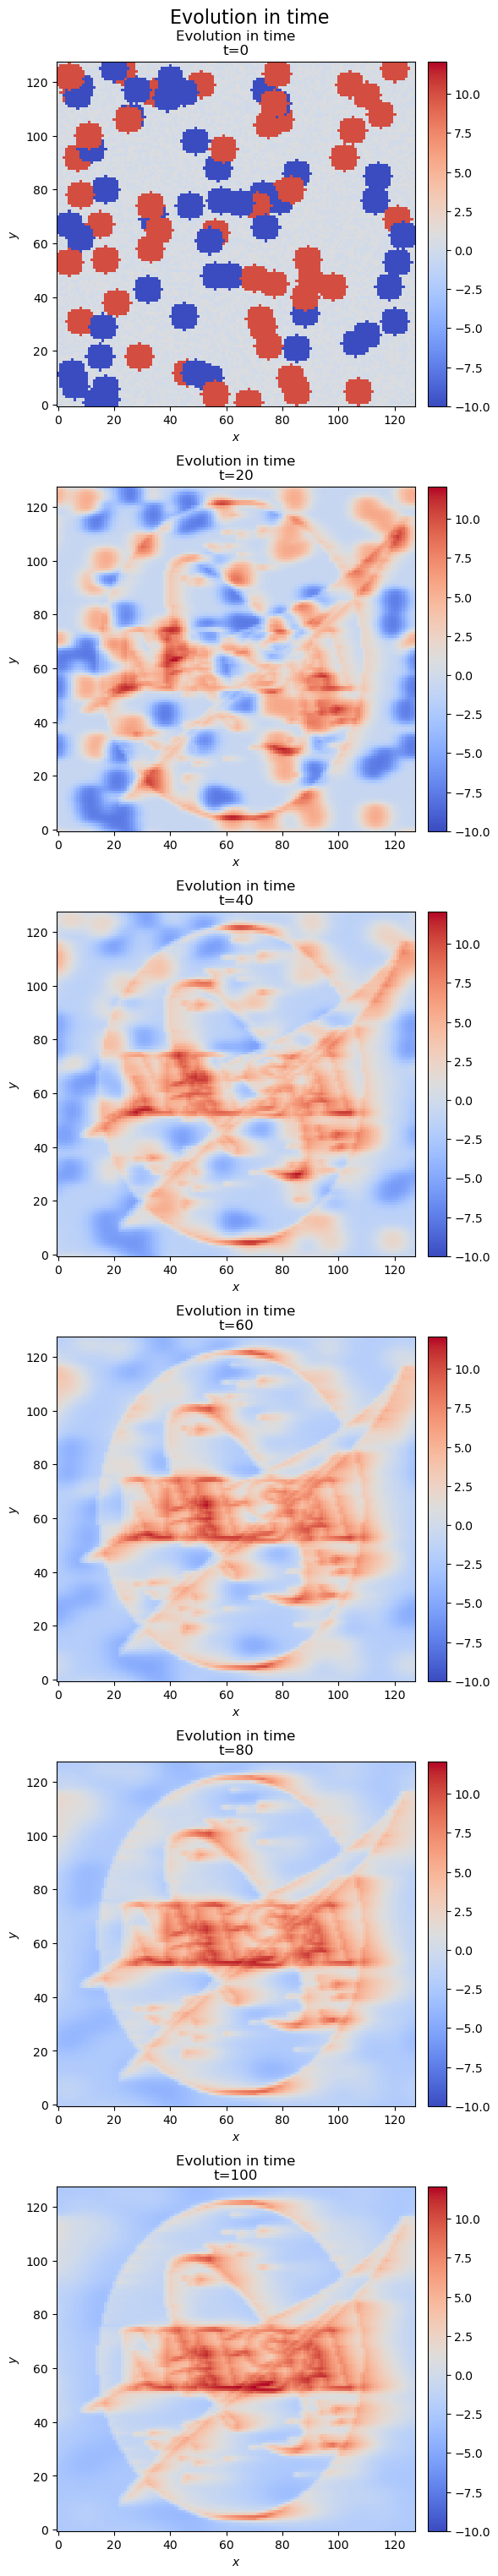

In [8]:
nr,nc = 128,128
c0 = np.random.rand(nr,nc)
c0 = helper.add_random_circles(c0, 100, 5, [-10,10])
c0 = c0.reshape(nr*nc,1)  ##FLATTEN IS BAD DO NOT FLATTEN

KX   = 3 * np.ones((nr,nc+1))
KY   = 3 * np.ones((nr+1,nc))

DX_C = 1 * np.ones((nr,nc+1))
DY_C = 1 * np.ones((nr+1,nc))

DX_G = 1 * np.ones((nr+1,nc))
DY_G = 1 * np.ones((nr,nc+1))

VX   = 30 * np.ones((nr,nc+1))
VY   = 1 * np.ones((nr+1,nc))

RAC  = 1 * np.ones((nr,nc))

F = 0.02
f = np.where(helper.NASA_map == 0, -3, 20).reshape(nr*nc,1)


M = make_M_2d_diffusion_advection_forcing(nr = nr, nc = nc, dt = 0.01,
                                    KX = KX, KY = KY,
                                    DX_C = DX_C , DY_C = DY_C,
                                    DX_G = DX_G,  DY_G = DY_G,
                                    VX = VX, VY = VY,
                                    RAC = RAC, F = F,
                                    cyclic_east_west = True, cyclic_north_south = True)

num_saved_timesteps = 6
duration_per_saved_timestep = 20

saved_timesteps, state_over_time = helper.compute_affine_time_evolution_simple(
                        c0, M, F*f, num_saved_timesteps, duration_per_saved_timestep, debug=True)
                        
helper.plot_2d_heatmap_time_evolution(saved_timesteps, state_over_time, nr, nc)

